# Noisy devices with Forest SDK

In this exasmple, we will redo the qubit rotation but instead of using the default *NumPy/autograd* QNode interface, we’ll use the [PyTorch interface](https://pennylane.readthedocs.io/en/latest/code/interfaces/torch.html#torch-qnode). We’ll also replace the `default.qubit` device with a noisy `forest.qvm` device to see how the optimization responds to noisy qubits.

<div class="admonition note">

<div class="admonition-title">Note</div>

To follow along with this tutorial on your own computer, you will require the the following dependencies:

- The [Forest SDK](https://www.rigetti.com/forest) which contains the *Quantum Virtual Machine (QVM)* and quilc quantum compiler. Once installed, the QVM and quilc can be started by running the commands `quilc -S` and `qvm -S` in separate terminal windows.

- [PennyLane-Forest plugin](https://github.com/rigetti/pennylane-forest) in order to access the QVM as a PennyLane device. This can be installed via pip: 

`pip install pennylane-forest`

- [PyTorch](https://pytorch.org/get-started/locally/) in order to access the PyTorch QNode interface. Follow the link for instructions on the best way to install PyTorch for your system.

</div>

</div>

### Loading The Plugin Device

Once the dependencies above are installed, let’s begin importing the required packages and setting up our quantum device.

To start with, we import PennyLane and PyTorch:

In [1]:
import pennylane as qml
import torch
from torch.autograd import Variable

<div class="admonition note">

<div class="admonition-title">Note</div>

We do not need to import the wrapped version of NumPy provided by PennyLane as we are not using the default QNode NumPy interface. If NumPy is needed, it is fine to import vanilla NumPy for use with PyTorch and TensorFlow.

</div>

</div>

In [2]:
# create a device
dev = qml.device('forest.qvm', device='2q-pyqvm', noisy=True)

Here we create a noisy two-qubit system simulated via the QVM. If we wish, we could also build the model on a physical device, such as the `Aspen-1` QPU.

### Constructing the QNode

Now that we have initialized the device, we can construct our quantum node. Like the other tutorials, we use the `qnode decorator` to convert our quantum function (encoded by the circuit above) into a quantum node running on the QVM.

In [3]:
@qml.qnode(dev, interface='torch')
def circuit(phi, theta):
    qml.RX(theta, wires=0)
    qml.RZ(phi, wires=0)
    return qml.expval.PauliZ(0)

<div class="admonition note">

<div class="admonition-title">Note</div>

To make the QNode "PyTorch aware", we need to specify that the QNode interfaces with PyTorch. This is done by passing the `interface='torch'` keyword argument. 

As a result, this QNode will be set up to accept and return PyTorch tensors and will also automatically calculate any analytic gradients when PyTorch performs backpropagation.

</div>

</div>

### Optimization

We can now create our optimization cost function. To introduce some additional complexity into the system, rather than simply training the variational circuit to ‘flip a qubit’ from state $\mid0\rangle$ to state $\mid1\rangle$, let’s also modify the target state every 100 steps. For example, for the first 100 steps, the target state will be $\mid1\rangle$; this will then change to $\mid0\rangle$ for steps 100 and 200, before changing back to state $\mid1\rangle$ for steps 200 to 300, and so on.

In [4]:
def cost(phi, theta, step):
    target = -(-1)**(step // 100)
    return torch.abs(circuit(phi, theta) - target)**2

Now that the cost function is defined, we can begin the PyTorch optimization. We create two variablesn representing the two free parameters of the variational circuit and initialize an Adam optimizer:

In [5]:
phi = Variable(torch.tensor(1.), requires_grad=True)
theta = Variable(torch.tensor(0.05), requires_grad=True)
opt = torch.optim.Adam([phi, theta], lr = 0.1)

<div class="admonition note">

<div class="admonition-title">Note</div>

As we are using the PyTorch interface, we must use PyTorch optimizers, not the built-in optimizers provided by PennyLane. The built-in optimizers only apply to the default NumPy/autograd interface.

</div>

</div>

Optimizing the system for 400 steps:

In [6]:
for i in range(400):
    opt.zero_grad()
    loss = cost(phi, theta, i)
    loss.backward()
    opt.step()

We can now check the final values of the parameters as well as the final circuit output and cost function:

In [7]:
phi

tensor(1.3375, requires_grad=True)

In [8]:
theta

tensor(12.7740, requires_grad=True)

In [9]:
circuit(phi,theta)

tensor(0.9785, dtype=torch.float64, grad_fn=<_TorchQNodeBackward>)

In [10]:
cost(phi, theta, 400)

tensor(3.9068, dtype=torch.float64, grad_fn=<PowBackward0>)

As the cost function is step-dependent, this does not provide enough detail to determine if the optimization was successful. Instead, let’s plot the output state of the circuit over time on a Bloch sphere:

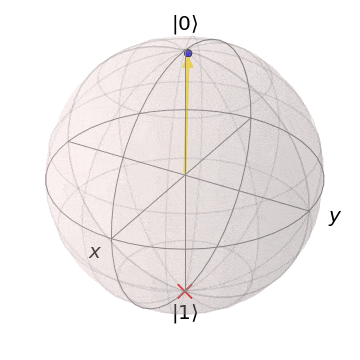

Here, the red cross is the target state of the variational circuit and the moving arrow is the variational circuit's output state. As the target state changes, the circuit learns to produce the new target state!